# Using LangGraph to Add Memory to Your Chatbot

## Building a ChatBot Memory System

In [1]:
from langchain_ollama import OllamaLLM
from langchain_core.prompts import ChatPromptTemplate

prompt = ChatPromptTemplate.from_messages([
    ("system","""You are a helpful assistant that can answer questions and help with tasks."""),
    ('placeholder',"{messages}")
])
model  = OllamaLLM(model='qwen3:1.7b')
chain = prompt|model
chain.invoke({
    "messages":[
        ("human","What is the capital of France?"),
        ("ai","The capital of France is Paris."),
        ("human","what did you say just now?")
    ]
})

'<think>\nOkay, the user asked, "What is the capital of France?" and I responded with "The capital of France is Paris." Now they\'re asking, "What did you say just now?" Let me make sure I understand their question correctly.\n\nThey want to know what I said in the previous message. Since I just provided the answer, I need to confirm that. The user might be checking if I remembered the correct answer or if there\'s any confusion. I should restate the answer clearly to ensure they understand. Also, maybe they want to verify if my response was accurate. I should keep it simple and straightforward, just reiterating the information without any extra details. Let me make sure the response is polite and helpful.\n</think>\n\nYou asked, "What did you say just now?"  \nI replied, "The capital of France is Paris."  \nLet me know if you need further clarification! 😊'

***While this is simple and it works, when taking your application to production,you’ll*** ***facesomemore challenges related to managing memory at scale, such as:***

You’ll need to update the memory after every interaction, atomically (i.e.,
don’t record only the question or only the answer in the case of failure).

You’ll want to store these memories in durable storage, such as a relational
database.

You’ll want to control how many and which messages are stored for later, and
how many of these are used for new interactions.

You’ll want to inspect and modify this state (for now, just a list of messages)
outside a call to an LLM.

We’ll now introduce some better tooling, which will help with this and all later
chapters.

### Langgraph

#### Creating a StateGraph

In [2]:
from typing import Annotated , TypedDict
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_ollama import OllamaLLM
from langchain_core.messages import HumanMessage

class State(TypedDict):
    messages:Annotated[list,add_messages]
builder = StateGraph(State) # Create a state graph with name builder
model=OllamaLLM(model="qwen3:1.7b")

def chatbot(state:State):
    answer = model.invoke(state['messages'])
    return {'messages':[answer]}


builder.add_node('chatbot',chatbot) # Add a node to the graph

builder.add_edge(START,'chatbot') # Add an edge from the start node to the chatbot node

builder.add_edge('chatbot',END) # Add an edge from the chatbot node to the end node

graph = builder.compile() # Compile the graph



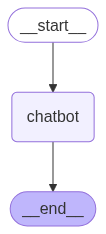

In [3]:
# Get PNG OF graph  
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(png_bytes))

In [4]:
input = {'messages':[HumanMessage('hi!')]}
for chunk in graph.stream(input):
    print(chunk)

{'chatbot': {'messages': ['<think>\nOkay, the user said "hi!" so I need to respond politely. Let me make sure my reply is friendly and open-ended. Maybe ask how they\'re doing? That\'s a common way to start a conversation. I should keep it simple and not too formal. Let me check for any grammar issues. Yep, looks good. Alright, time to send the response.\n</think>\n\nHi! How are you doing today? 😊 I\'m doing great, thanks! How about you?']}}


#### Adding Memory to LangGraph 

In [5]:
from langgraph.checkpoint.memory import MemorySaver

graph = builder.compile(checkpointer = MemorySaver())

**below code used as memory to chatbot**

In [ ]:
thread1 = {'configurable':{"thread_id":"1"}} # Create a memory box with id 1

result_1 = graph.invoke({"messages":[HumanMessage('hi, my name is manish')]},thread1) # call the chatbot with a message and result_1 store the response
print(result_1)
result_2 = graph.invoke(
    {"messages":[HumanMessage("what is my name?")]},thread1
)
print(result_2)


{'messages': [HumanMessage(content='hi, my name is manish', additional_kwargs={}, response_metadata={}, id='1ad8d702-4bc4-498f-89c0-d318a544773f'), HumanMessage(content='<think>\nOkay, the user said, "hi, my name is manish." So they\'re introducing themselves. I need to respond in a friendly and helpful way.\n\nFirst, I should acknowledge their greeting. Maybe say "Hello!" to be polite. Then ask how they\'re doing. "How are you today?" is a common question. \n\nThey mentioned their name, so I can add that to the response. "My name is Manish" – maybe use their name as is, but the user wrote "manish" with an \'m\' and \'a\'... Wait, the user wrote "manish" with an \'m\' and \'a\'? Wait, no, the user wrote "manish" – let me check. The original message was "hi, my name is manish". So "manish" is spelled with an \'m\' and \'a\'... Wait, no, actually, "manish" is spelled M-A-N-I-S-H. So the user wrote "manish" with an \'m\' and \'a\'... Wait, no, "manish" is spelled M-A-N-I-S-H. So the user\

In [ ]:
graph.get_state(thread1) # return the current state of Thread

StateSnapshot(values={'messages': [HumanMessage(content='hi, my name is manish', additional_kwargs={}, response_metadata={}, id='1ad8d702-4bc4-498f-89c0-d318a544773f'), HumanMessage(content='<think>\nOkay, the user said, "hi, my name is manish." So they\'re introducing themselves. I need to respond in a friendly and helpful way.\n\nFirst, I should acknowledge their greeting. Maybe say "Hello!" to be polite. Then ask how they\'re doing. "How are you today?" is a common question. \n\nThey mentioned their name, so I can add that to the response. "My name is Manish" – maybe use their name as is, but the user wrote "manish" with an \'m\' and \'a\'... Wait, the user wrote "manish" with an \'m\' and \'a\'? Wait, no, the user wrote "manish" – let me check. The original message was "hi, my name is manish". So "manish" is spelled with an \'m\' and \'a\'... Wait, no, actually, "manish" is spelled M-A-N-I-S-H. So the user wrote "manish" with an \'m\' and \'a\'... Wait, no, "manish" is spelled M-A-

### Modifying Chat History

#### Trimming Messages

In [10]:
from langchain_core.messages import SystemMessage,trim_messages,HumanMessage,AIMessage

messages = [
    SystemMessage(content="you're a good assistant"),
    HumanMessage(content="hi! I'm manish"),
    AIMessage(content="hi!"),
    HumanMessage(content="I like vanilla ice cream"),
    AIMessage(content="nice"),
    HumanMessage(content="whats 2 + 2"),
    AIMessage(content="4"),
    HumanMessage(content="thanks"),
    AIMessage(content="no problem!"),
    HumanMessage(content="having fun?"),
    AIMessage(content="yes!"),
]
trimmer = trim_messages(
    max_tokens = 65,
    strategy ="last",
    token_counter = OllamaLLM(model="llama3.2:3b"),
    include_system = True,
    allow_partial=False,
    start_on="human",
)

trimmed = trimmer.invoke(messages)
print(trimmed)


/opt/anaconda3/envs/GEN_ENV/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[SystemMessage(content="you're a good assistant", additional_kwargs={}, response_metadata={}), HumanMessage(content="hi! I'm manish", additional_kwargs={}, response_metadata={}), AIMessage(content='hi!', additional_kwargs={}, response_metadata={}), HumanMessage(content='I like vanilla ice cream', additional_kwargs={}, response_metadata={}), AIMessage(content='nice', additional_kwargs={}, response_metadata={}), HumanMessage(content='whats 2 + 2', additional_kwargs={}, response_metadata={}), AIMessage(content='4', additional_kwargs={}, response_metadata={}), HumanMessage(content='thanks', additional_kwargs={}, response_metadata={}), AIMessage(content='no problem!', additional_kwargs={}, response_metadata={}), HumanMessage(content='having fun?', additional_kwargs={}, response_metadata={}), AIMessage(content='yes!', additional_kwargs={}, response_metadata={})]


#### Filtering Messages

In [8]:
from langchain_core.messages import (
    AIMessage,
    HumanMessage,
    SystemMessage,
    filter_messages,
)

# Sample messages
messages = [
    SystemMessage(content="you are a good assistant", id="1"),
    HumanMessage(content="example input", id="2", name="example_user"),
    AIMessage(content="example output", id="3", name="example_assistant"),
    HumanMessage(content="real input", id="4", name="bob"),
    AIMessage(content="real output", id="5", name="alice"),
]
human_messages = filter_messages(messages,include_types = "human")
print("Human messages:", human_messages)

excluded_name = filter_messages(
    messages,exclude_names=['example_user','example_assistant']
)

print("\nExcluding example names:", excluded_name)

filtered_messages = filter_messages(
    messages,include_types=["human","ai"],exclude_ids=["3"]
    
)
print("\nFiltered by types and IDs:",filtered_messages)


Human messages: [HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'), HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4')]

Excluding example names: [SystemMessage(content='you are a good assistant', additional_kwargs={}, response_metadata={}, id='1'), HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4'), AIMessage(content='real output', additional_kwargs={}, response_metadata={}, name='alice', id='5')]

Filtered by types and IDs: [HumanMessage(content='example input', additional_kwargs={}, response_metadata={}, name='example_user', id='2'), HumanMessage(content='real input', additional_kwargs={}, response_metadata={}, name='bob', id='4'), AIMessage(content='real output', additional_kwargs={}, response_metadata={}, name='alice', id='5')]


In [9]:
filter = filter_messages(excluded_name=["example_user"])
chain = filter|model
print(chain)

first=RunnableLambda(...) middle=[] last=OllamaLLM(model='qwen3:1.7b')


#### Merging Consecutive Messages

In [11]:
from langchain_core.messages import merge_message_runs
messages = [
    SystemMessage(content="you're a good assistant."),
    SystemMessage(content="you always respond with a joke."),
    HumanMessage(
        content=[{"type": "text", "text": "i wonder why it's called langchain"}]
    ),
    HumanMessage(content="and who is harrison chasing anyways"),
    AIMessage(
        content='Well, I guess they thought "WordRope" and "SentenceString" just didn\'t have the same ring to it!'
    ),
    AIMessage(
        content="Why, he's probably chasing after the last cup of coffee in the office!"
    ),
    SystemMessage(content="how good this function is lets see"),
]
merged = merge_message_runs(messages)
print(merged)

[SystemMessage(content="you're a good assistant.\nyou always respond with a joke.", additional_kwargs={}, response_metadata={}), HumanMessage(content=[{'type': 'text', 'text': "i wonder why it's called langchain"}, 'and who is harrison chasing anyways'], additional_kwargs={}, response_metadata={}), AIMessage(content='Well, I guess they thought "WordRope" and "SentenceString" just didn\'t have the same ring to it!\nWhy, he\'s probably chasing after the last cup of coffee in the office!', additional_kwargs={}, response_metadata={}), SystemMessage(content='how good this function is lets see', additional_kwargs={}, response_metadata={})]


In [12]:
merger = merge_message_runs()
chain = merger | model